In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from pyCompare import blandAltman

test_path = "../results/hold-out-test.csv"
val_path = "../results/internal-val-data.csv"

external_all_path = "../results/external-data.csv"
prospective_all_path = "../results/prospective-data.csv"

figureSize = (4, 4)


def dice_plot(
    x,
    y,
    title,
    figureSize=figureSize,
    x_label="Reference htTKV (mL)",
    y_label="Dice Similarity Coefficient",
):

    dpi = 72
    fig, ax = plt.subplots(figsize=figureSize, dpi=dpi)
    draw = True
    meanColour = "#6495ED"
    loaColour = "coral"
    pointColour = "#6495ED"

    ax.scatter(x, y, alpha=0.5, c=pointColour)

    mean = np.mean(y)
    sd = np.std(y)
    sd95 = 1.96 * np.std(y)
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    offset = 0.08
    ax.text(
        0.97,
        mean - 2 * offset,
        f"Mean {mean:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        mean - 3 * offset,
        f"SD {sd:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        mean - 4 * offset,
        f"±1.96 SD in coral",
        ha="right",
        va="bottom",
        transform=trans,
    )

    ax.axhspan(mean - sd95, mean + sd95, facecolor=loaColour, alpha=0.2)

    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, pad=10)
    ax.set_ylim([0, 1.05])
    ax.axhline(np.mean(y), color=meanColour, linestyle="--")

    ax.set_yticks(np.arange(0, 1.1, 0.1))



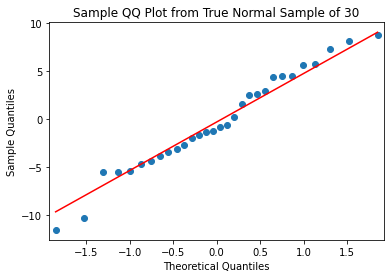

In [2]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(30)
# q-q plot
qqplot(data, line='s')
plt.title("Sample QQ Plot from True Normal Sample of 30")
pyplot.show()

In [3]:
# external_ds = pd.read_csv(external_path)
# prospective_ds = pd.read_csv(prospective_path)
prospective_ds = pd.read_csv(prospective_all_path)
prospective_ds.TKV_Pred /= 1000  # corrects units to mL
prospective_ds.TKV_GT /= 1000  # corrects units to mL

test_ds = pd.read_csv(test_path)
test_ds.TKV_GT /= 1000  # corrects units to mL
test_ds.TKV_Pred /= 1000  # corrects units to mL


external_ds = pd.read_csv(external_all_path)

val_ds = pd.read_csv(val_path)
val_ds.TKV_GT /= 1000  # corrects units to mL
val_ds.TKV_Pred /= 1000  # corrects units to mL



# Prospective

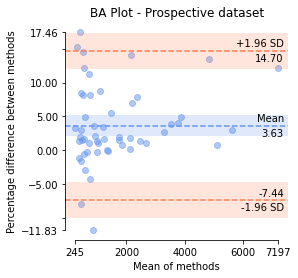

In [4]:

blandAltman(
    prospective_ds.TKV_GT,
    prospective_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Prospective dataset",
    figureSize=figureSize,
)

Mean difference (Prospective)= 3.63


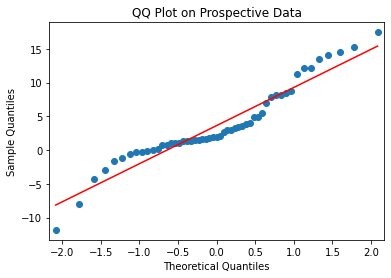

In [5]:
mean = np.mean([prospective_ds.TKV_GT, prospective_ds.TKV_Pred], axis=0)
diff = ((prospective_ds.TKV_GT - prospective_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)

print(f"Mean difference (Prospective)= {md:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Prospective Data")
pyplot.show()

In [6]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.79, 6.97) = 6.18


# External

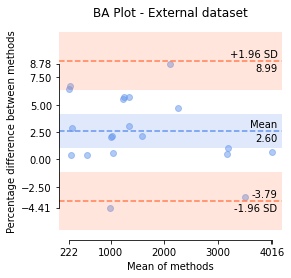

In [7]:
blandAltman(
    external_ds.TKV_GT,
    external_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - External dataset",
    figureSize=figureSize,
)

Mean difference (External)= 2.60


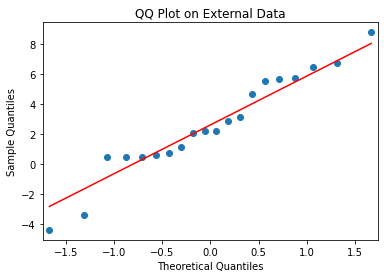

In [8]:
mean = np.mean([external_ds.TKV_GT, external_ds.TKV_Pred], axis=0)
diff = ((external_ds.TKV_GT - external_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)

print(f"Mean difference (External)= {md:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on External Data")
pyplot.show()

In [9]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.54, 5.61) = 5.08


# Internal Hold-out Test

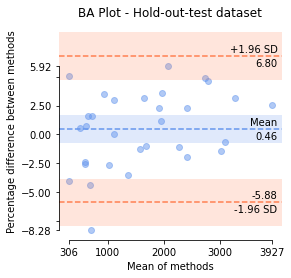

In [10]:
blandAltman(
    test_ds.TKV_GT,
    test_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Hold-out-test dataset",
    figureSize=figureSize,
)



Mean difference (Hold-out)= 0.46


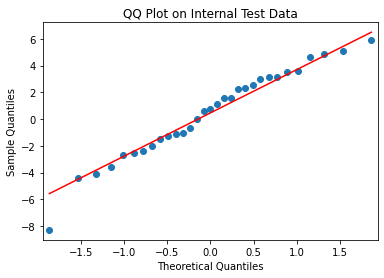

In [11]:
mean = np.mean([test_ds.TKV_GT, test_ds.TKV_Pred], axis=0)
diff = ((test_ds.TKV_GT - test_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)

print(f"Mean difference (Hold-out)= {md:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Test Data")
pyplot.show()

In [12]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (-1.73, 3.07) = 4.80


# Internal Val

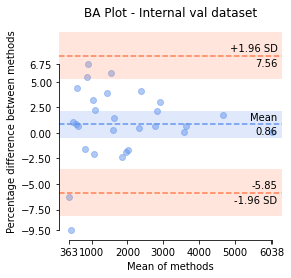

In [13]:
blandAltman(
    val_ds.TKV_GT,
    val_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Internal val dataset",
    figureSize=figureSize,
)


Mean difference (Hold-out)= 0.86


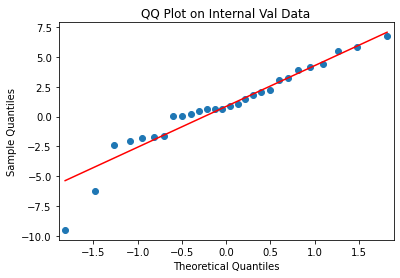

In [14]:
mean = np.mean([val_ds.TKV_GT, val_ds.TKV_Pred], axis=0)
diff = ((val_ds.TKV_GT - val_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)

print(f"Mean difference (Hold-out)= {md:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Val Data")
pyplot.show()

In [15]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (-0.78, 3.15) = 3.94


# Dice Plots

## Prospective


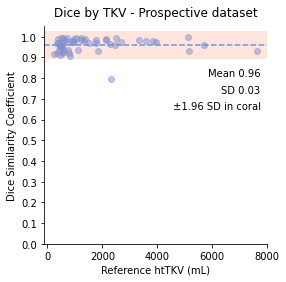

In [16]:
dice_plot(
    prospective_ds.TKV_GT,
    prospective_ds.patient_dice,
    title="Dice by TKV - Prospective dataset",
    figureSize=figureSize,
)

In [17]:
# First quartile (Q1)
Q1 = np.percentile(prospective_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(prospective_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.94, 0.98) = 0.05


## External

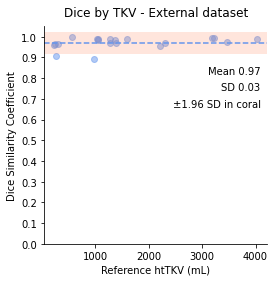

In [18]:
dice_plot(
    external_ds.TKV_GT,
    external_ds.patient_dice,
    title="Dice by TKV - External dataset",
    figureSize=figureSize,
)

In [19]:
# First quartile (Q1)
Q1 = np.percentile(external_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(external_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.96, 0.99) = 0.02


## Hold-Out Test

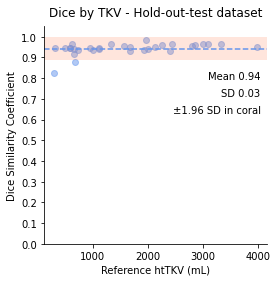

In [20]:
dice_plot(
    test_ds.TKV_GT,
    test_ds.patient_dice,
    title="Dice by TKV - Hold-out-test dataset",
    figureSize=figureSize,
)

In [21]:
# First quartile (Q1)
Q1 = np.percentile(test_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(test_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.94, 0.96) = 0.02


## Internal Val

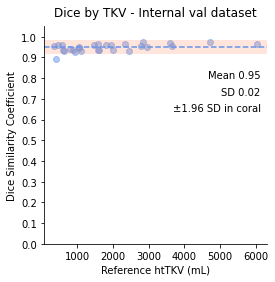

In [22]:
dice_plot(
    val_ds.TKV_GT,
    val_ds.patient_dice,
    title="Dice by TKV - Internal val dataset",
    figureSize=figureSize,
)

In [23]:
# First quartile (Q1)
Q1 = np.percentile(val_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(val_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")

IQRs (25, 75) = (0.94, 0.96) = 0.03
